In [ ]:
################################## KENNETH EKPETERE #################################
############################## KM vs PMP Monotonic Curve ###############################
##################################### (C) 2025  ########################################

In [1]:
import time
import sys
from datetime import date
from datetime import datetime, timedelta
import math
import statistics
from math import exp
from scipy.stats import tmean, tstd

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

### Pair KM and PMP for Analysis

In [18]:
"""
Function to compute frequency factors and combine them with PMP data.

Steps:
1. Reads max_file and PMP_file.
2. Removes IDs with PMP inversions.
3. Computes frequency factor (freqfact), mean, std, and max per unique ID for durations.
4. Combines results into a single CSV file:
   - ID, lat, lon
   - km_* (frequency factors)
   - pmp_* (non-inverted PMP)
   - std_*, mean_*, max_* (computed from max_file)
"""
    
def pair_frequency_factor_to_pmp(max_file: str, PMP_file: str, output_file: str):

    # -------------------------------
    # Step 1: Read input data
    # -------------------------------
    print("Reading input files...")
    max_df = pd.read_csv(max_file)
    pmp_df = pd.read_csv(PMP_file)

    # Duration fields
    duration_fields = ['30-min', '1-hour', '2-hour', '3-hour', '6-hour',
                       '12-hour', '24-hour', '48-hour', '72-hour']

    required_pmp_cols = ['ID'] + duration_fields
    required_max_cols = ['ID', 'lat', 'lon'] + [d for dur in duration_fields for d in [dur, f'year_{dur}']]

    if not all(col in pmp_df.columns for col in required_pmp_cols):
        raise ValueError("PMP file missing required columns.")
    if not all(col in max_df.columns for col in required_max_cols):
        raise ValueError("Max file missing required columns.")

    # -------------------------------
    # Step 2: Detect and remove inversions
    # -------------------------------
    print("Checking for PMP inversions...")
    duration_pairs = [
        ('30-min', '1-hour'),
        ('1-hour', '2-hour'),
        ('2-hour', '3-hour'),
        ('3-hour', '6-hour'),
        ('6-hour', '12-hour'),
        ('12-hour', '24-hour'),
        ('24-hour', '48-hour'),
        ('48-hour', '72-hour')
    ]

    pmp_df['inverted'] = pmp_df.apply(
        lambda row: any(row[short] > row[long] for short, long in duration_pairs),
        axis=1
    )

    inverted_records = pmp_df[pmp_df['inverted'] == True].copy()
    non_inverted = pmp_df[pmp_df['inverted'] == False].copy().drop(columns=['inverted'])

    # Save inverted records
    inverted_records.to_csv("zzz1_inversionID.csv", index=False)
    print(f"Inversion check complete: {len(inverted_records)} inversions found and saved to 'zzz1_inversionID.csv'")

    # -------------------------------
    # Step 3: Compute statistics and frequency factors
    # -------------------------------
    print("Computing frequency factors, mean, std, and max values...")
    freqfact_list = []

    for uid in non_inverted['ID']:
        subset = max_df[max_df['ID'] == uid]
        if subset.empty:
            continue

        # Basic statistics
        max_pre = subset[duration_fields].max()
        mean_pre = subset[duration_fields].mean()
        std_pre = subset[duration_fields].std()

        # Trimmed statistics (excluding largest value)
        trimmed_mean = subset[duration_fields].apply(lambda x: np.mean(np.sort(x)[:-1]) if len(x) > 1 else np.mean(x))
        trimmed_std = subset[duration_fields].apply(lambda x: np.std(np.sort(x)[:-1], ddof=1) if len(x) > 1 else np.std(x, ddof=1))

        # Frequency factor
        freqfact = (max_pre - trimmed_mean) / trimmed_std

        rec = {'ID': uid, 'lat': subset['lat'].iloc[0], 'lon': subset['lon'].iloc[0]}

        for d in duration_fields:
            dur_hr = d.replace("-hour", "-hr")  # keep consistent naming
            rec[f'km_{dur_hr}'] = freqfact[d]
            rec[f'mean_{dur_hr}'] = mean_pre[d]
            rec[f'std_{dur_hr}'] = std_pre[d]
            rec[f'max_{dur_hr}'] = max_pre[d]

        freqfact_list.append(rec)

    freqfact_df = pd.DataFrame(freqfact_list)

    # -------------------------------
    # Step 4: Combine freqfact + PMP data
    # -------------------------------
    print("Combining results...")
    merged = pd.merge(non_inverted, freqfact_df, on='ID', how='inner')

    # Rename PMP columns
    for d in duration_fields:
        merged.rename(columns={d: f'pmp_{d.replace("-hour", "-hr")}'}, inplace=True)

    # Build final column order
    ordered_cols = (
        ['ID', 'lat', 'lon'] +
        [f'km_{d.replace("-hour", "-hr")}' for d in duration_fields] +
        [f'pmp_{d.replace("-hour", "-hr")}' for d in duration_fields] +
        [f'mean_{d.replace("-hour", "-hr")}' for d in duration_fields] +
        [f'std_{d.replace("-hour", "-hr")}' for d in duration_fields] +
        [f'max_{d.replace("-hour", "-hr")}' for d in duration_fields]
    )

    final_df = merged[ordered_cols]

    # -------------------------------
    # Step 5: Save final output
    # -------------------------------
    final_df.to_csv(output_file, index=False)
    print(f"Process complete! Final results saved to: {output_file}")

    # Return dataframes for optional interactive use
    # return final_df, non_inverted, inverted_records

In [19]:
# Run Function
print("Computing frequency factors and PMP associations.")
max_file = "alltime_partial_duration_max.csv"
PMP_file = "alltime_partial_duration_max_pmp.csv"
output_file = "zzz2_model_training_parameters.csv"
pair_frequency_factor_to_pmp(max_file, PMP_file, output_file)

Computing frequency factors and PMP associations.
Reading input files...
Checking for PMP inversions...
Inversion check complete: 1119 inversions found and saved to 'zzz1_inversionID.csv'
Computing frequency factors, mean, std, and max values...
Combining results...
Process complete! Final results saved to: zzz2_paired_km_pmp.csv


#### Curve Fitting Frequency factor vs PMP 

In [41]:

"""
Fits separate PMP–frequency factor (km) curves per duration while enforcing monotonic PMP increase.
Exports both the fitted PMP–km curve results and the fitted parameter coefficients to CSV.

Equation form:
    PMP = c * (km + a)^n + b * mean + d * std + e * max

Parameters
----------
input_file : str
    Path to input CSV containing km, pmp, mean, std, and max values per duration.
output_curve_file : str
    Path to output CSV file for storing the fitted PMP–km curves.
param_export_file : str, optional
    Path to export fitted parameters (CSV). Default is 'fitted_pmp_parameters.csv'.

Returns
-------
tuple
    (result_df, fitted_params_df)
"""


def frequency_factor_to_pmp_curve_fitter(input_file, output_curve_file, param_export_file):

    # -------------------------------
    # Step 1: Read and prepare data
    # -------------------------------
    print("Reading input data...")
    df = pd.read_csv(input_file)

    durations = ['30-min', '1-hr', '2-hr', '3-hr', '6-hr', '12-hr', '24-hr', '48-hr', '72-hr']
    paired_data = []

    for dur in durations:
        km_col = f'km_{dur}'
        pmp_col = f'pmp_{dur}'
        mean_col = f'mean_{dur}'
        std_col = f'std_{dur}'
        max_col = f'max_{dur}'

        if all(col in df.columns for col in [km_col, pmp_col, mean_col, std_col, max_col]):
            temp = df[['ID', km_col, pmp_col, mean_col, std_col, max_col]].copy()
            temp.rename(columns={
                km_col: 'km',
                pmp_col: 'pmp',
                mean_col: 'mean',
                std_col: 'std',
                max_col: 'max'
            }, inplace=True)
            temp['duration'] = dur
            paired_data.append(temp)

    if not paired_data:
        raise ValueError("No valid duration fields found in input file.")

    data = pd.concat(paired_data, ignore_index=True).dropna()

    # -------------------------------
    # Step 2: (Optional) Outlier filtering
    # -------------------------------
    print("Filtering extreme outliers (currently disabled)...")
    for col in ['km', 'pmp', 'mean', 'std', 'max']:
        z = (data[col] - data[col].mean()) / data[col].std()
        # data = data[np.abs(z) < 3]
    print(f"Remaining samples: {len(data)}")

    # -------------------------------
    # Step 3: Define nonlinear PMP model
    # -------------------------------
    def pmp_model(vars, c, a, n, b, d, e):
        km, mean, std, maxv = vars
        return c * (km + a) ** n + b * mean + d * std + e * maxv

    km_points = np.array([0, 2, 4, 6, 8, 10, 12, 14], dtype=float)
    mean_ref = data['mean'].mean()
    std_ref = data['std'].mean()
    max_ref = data['max'].mean()

    results = []
    fitted_rows = []

    # -------------------------------
    # Step 4: Fit curve per duration
    # -------------------------------
    print("Fitting PMP–km curve for each duration...")

    for dur in durations:
        subset = data[data['duration'] == dur]
        if subset.empty:
            print(f"Skipping {dur} — no valid data.")
            continue

        X = np.vstack((subset['km'], subset['mean'], subset['std'], subset['max']))
        y = subset['pmp']

        try:
            popt, _ = curve_fit(
                pmp_model, X, y,
                p0=[1.0, 0.1, 1.0, 0.1, 0.1, 0.1],
                maxfev=20000
            )
            c, a, n, b, d, e = popt
        except Exception as err:
            print(f"Fitting failed for {dur}: {err}. Using fallback defaults.")
            c, a, n, b, d, e = 1.0, 0.1, 1.0, 0.1, 0.1, 0.1

        # Store fitted parameters
        fitted_rows.append({
            "duration": dur,
            "c": c, "a": a, "n": n,
            "b": b, "d": d, "e": e
        })

        # Predict PMP for standard km points
        pmp_est = pmp_model((km_points, mean_ref, std_ref, max_ref), c, a, n, b, d, e)
        results.append(pd.DataFrame({'duration': dur, 'km': km_points, 'pmp_estimated': pmp_est}))

    result_df = pd.concat(results, ignore_index=True)
    fitted_params_df = pd.DataFrame(fitted_rows)

    # -------------------------------
    # Step 5: Enforce monotonic increase
    # -------------------------------
    print("Enforcing monotonic increase across durations...")

    for i in range(1, len(durations)):
        prev_dur = durations[i - 1]
        curr_dur = durations[i]

        prev_vals = result_df[result_df['duration'] == prev_dur]['pmp_estimated'].values
        curr_mask = result_df['duration'] == curr_dur
        curr_vals = result_df.loc[curr_mask, 'pmp_estimated'].values

        adjusted = np.maximum(curr_vals, prev_vals + 1e-3)
        result_df.loc[curr_mask, 'pmp_estimated'] = adjusted

    # -------------------------------
    # Step 6: Save fitted PMP curves
    # -------------------------------
    print("Saving fitted PMP–km curves...")
    output_pivot = result_df.pivot(index='km', columns='duration', values='pmp_estimated').reset_index()

    ordered_cols = ['km'] + durations
    for col in ordered_cols:
        if col not in output_pivot.columns:
            output_pivot[col] = np.nan
    output_pivot = output_pivot[ordered_cols]

    output_pivot.to_csv(output_curve_file, index=False)
    print(f"Curve fitting results saved to: {output_curve_file}")

    # -------------------------------
    # Step 7: Save fitted parameters to CSV
    # -------------------------------
    print("Saving fitted parameter coefficients...")
    fitted_params_df.to_csv(param_export_file, index=False, float_format="%.6f")
    print(f"Parameter coefficients saved to: {param_export_file}")

    # -------------------------------
    # Step 8: Plot all duration curves
    # -------------------------------
    plt.figure(figsize=(9, 6))
    for dur in durations:
        if dur in result_df['duration'].unique():
            sub = result_df[result_df['duration'] == dur]
            plt.plot(sub['pmp_estimated'], sub['km'], marker='o', label=dur)

    plt.xlabel("PMP (mm)")
    plt.ylabel("Frequency Factor (unitless)")
    plt.title("Monotonic PMP vs Frequency Factor Curves")
    plt.grid(True, linestyle='--', linewidth=0.6)
    plt.legend(title="Duration")
    plt.tight_layout()
    plt.show()

    print("Curve fitting and parameter export complete.")
    return result_df, fitted_params_df


Reading input data...
Filtering extreme outliers (currently disabled)...
Remaining samples: 11169
Fitting PMP–km curve for each duration...


C:\Users\kenne\AppData\Local\Temp\ipykernel_17284\2061996563.py:73: RuntimeWarning: invalid value encountered in power
  return c * (km + a) ** n + b * mean + d * std + e * maxv


Enforcing monotonic increase across durations...
Saving fitted PMP–km curves...
Curve fitting results saved to: zzz3_km_vs_pmp_per_duration.csv
Saving fitted parameter coefficients...
Parameter coefficients saved to: zzz4_fitted_pmp_parameters.csv


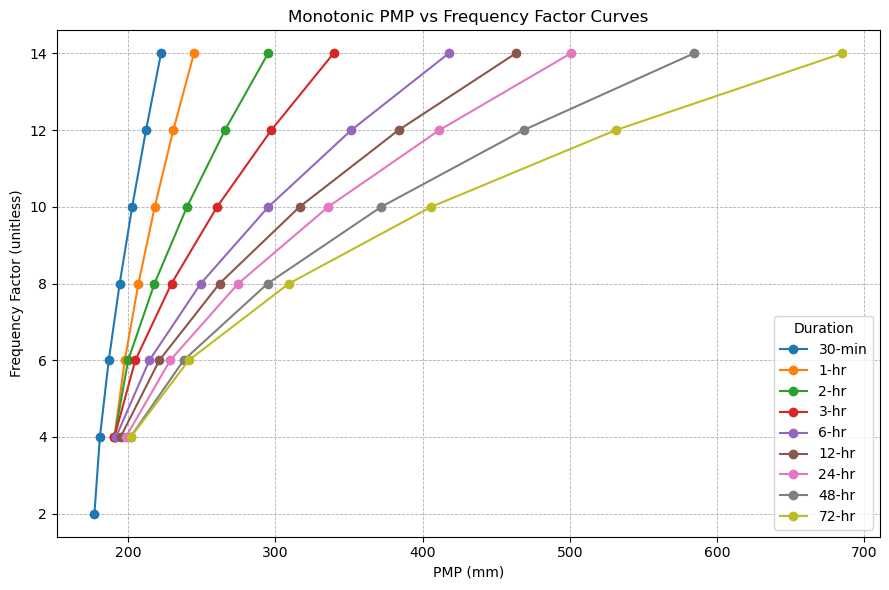

Curve fitting and parameter export complete.


(   duration    km  pmp_estimated
 0    30-min   0.0            NaN
 1    30-min   2.0     177.230944
 2    30-min   4.0     180.941945
 3    30-min   6.0     186.964915
 4    30-min   8.0     194.376589
 ..      ...   ...            ...
 67    72-hr   6.0     241.283423
 68    72-hr   8.0     309.330503
 69    72-hr  10.0     406.020160
 70    72-hr  12.0     531.281789
 71    72-hr  14.0     685.061652
 
 [72 rows x 3 columns],
   duration         c         a         n         b         d         e
 0   30-min  1.377937 -1.970650  1.403579  0.357034  2.393067  0.480193
 1     1-hr  1.337264 -2.064697  1.517964  0.347555  1.892534  0.604022
 2     2-hr  2.086840 -2.088148  1.614303  0.293555  1.884253  0.598418
 3     3-hr  2.417981 -2.006077  1.686364  0.345590  2.094441  0.539890
 4     6-hr  2.874053 -2.233578  1.784410  0.249708  1.839716  0.639229
 5    12-hr  3.027449 -2.138259  1.827051  0.197441  1.787524  0.679321
 6    24-hr  3.205348 -1.949192  1.842026  0.089347  1.622836 

In [42]:
# Run function

input_file = "zzz2_model_training_parameters.csv"
output_curve_file = "zzz3_sample_model_output.csv" 
param_export_file = "zzz4_parameter_coefficients.csv"
    
frequency_factor_to_pmp_curve_fitter(input_file, output_curve_file, param_export_file)

#### PMP Estimator: PMP–frequency factor equation derived from fitted parameters

In [39]:
"""
Computes PMP for each duration per unique ID using the enhanced nonlinear
PMP–frequency factor relationship derived from fitted parameters.

Automatically derives mean, std, max, and frequency factor (km) from the
input rainfall maxima per ID and duration.

Ensures PMP values increase monotonically with duration.
"""

# Compute PMP from fitted curve equation
def compute_pmp_from_enhanced_equation(input_file: str, output_file: str):

    print("Reading input data...")
    df = pd.read_csv(input_file, float_precision='round_trip')

    required_cols = {'ID', 'lat', 'lon'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Input file must contain columns: {required_cols}")

    # Durations as they appear in your dataset
    durations = ['30-min', '1-hour', '2-hour', '3-hour', '6-hour',
                 '12-hour', '24-hour', '48-hour', '72-hour']

    # Mapping to match parameter dictionary
    dur_map = {
        "30-min": "30-min",
        "1-hour": "1-hr",
        "2-hour": "2-hr",
        "3-hour": "3-hr",
        "6-hour": "6-hr",
        "12-hour": "12-hr",
        "24-hour": "24-hr",
        "48-hour": "48-hr",
        "72-hour": "72-hr"
    }

    # Fitted parameters (hard-coded)
    fitted_params = {
        "30-min": [1.377937, -1.97065, 1.403579, 0.357034, 2.393067, 0.480193],
        "1-hr":   [1.337264, -2.064697, 1.517964, 0.347555, 1.892534, 0.604022],
        "2-hr":   [2.086840, -2.088148, 1.614303, 0.293555, 1.884253, 0.598418],
        "3-hr":   [2.417981, -2.006077, 1.686364, 0.345590, 2.094441, 0.539890],
        "6-hr":   [2.874053, -2.233578, 1.784410, 0.249708, 1.839716, 0.639229],
        "12-hr":  [3.027449, -2.138259, 1.827051, 0.197441, 1.787524, 0.679321],
        "24-hr":  [3.205348, -1.949192, 1.842026, 0.089347, 1.622836, 0.756714],
        "48-hr":  [3.587194, -2.015809, 1.893751, -0.030377, 1.710306, 0.812457],
        "72-hr":  [3.675221, -2.293594, 1.991916, -0.104126, 2.117445, 0.808138],
    }

    def pmp_model(km, mean, std, maxv, params):
        c, a, n, b, d, e = params
        return c * (km + a) ** n + b * mean + d * std + e * maxv

    grouped = df.groupby('ID')
    results = []

    print("Computing enhanced PMP values for each unique ID...")

    for uid, group in grouped:
        lat = group['lat'].iloc[0]
        lon = group['lon'].iloc[0]

        row = {'ID': uid, 'lat': lat, 'lon': lon}

        # Compute basic stats per duration
        max_pre = group[durations].max()
        mean_pre = group[durations].mean()
        std_pre = group[durations].std(ddof=1)
        trimmed_mean = group[durations].apply(lambda x: np.mean(np.sort(x)[:-1]))
        trimmed_std = group[durations].apply(lambda x: np.std(np.sort(x)[:-1], ddof=1))
        freqfact = (max_pre - trimmed_mean) / trimmed_std

        for dur in durations:
            dur_key = dur_map[dur]  # ensures proper lookup in fitted_params
            params = fitted_params[dur_key]

            km = freqfact[dur]
            mean_val = mean_pre[dur]
            std_val = std_pre[dur]
            max_val = max_pre[dur]

            # compute PMP using the enhanced equation
            try:
                pmp_val = pmp_model(km, mean_val, std_val, max_val, params)
            except Exception as e:
                print(f"Error computing PMP for {uid}, {dur}: {e}")
                pmp_val = np.nan

            row[dur] = pmp_val

        results.append(row)

    output_df = pd.DataFrame(results)

    # Enforce monotonic increase across durations
    print("Enforcing monotonic increase across durations...")
    for i in range(1, len(durations)):
        prev_dur = durations[i - 1]
        curr_dur = durations[i]
        output_df[curr_dur] = np.maximum(output_df[curr_dur], output_df[prev_dur] + 1e-3)

    # Save output
    ordered_cols = ['ID', 'lat', 'lon'] + durations
    output_df = output_df[ordered_cols]
    output_df.to_csv(output_file, index=False, float_format="%.4f")

    print(f"Enhanced PMP computation complete. Results saved to: {output_file}")
    return output_df

In [40]:
# Run Function
input_file = "alltime_partial_duration_max.csv"
output_file = "zzz5_curve_fitted_pmp.csv"

compute_pmp_from_enhanced_equation(input_file, output_file)

Reading input data...
Computing enhanced PMP values for each unique ID...


C:\Users\kenne\AppData\Local\Temp\ipykernel_17284\4280174565.py:55: RuntimeWarning: invalid value encountered in double_scalars
  return c * (km + a) ** n + b * mean + d * std + e * maxv


Enforcing monotonic increase across durations...
Enhanced PMP computation complete. Results saved to: zzz5_curve_fitted_pmp.csv


,ID,lat,lon,30-min,1-hour,2-hour,3-hour,6-hour,12-hour,24-hour,48-hour,72-hour
0,2,33.4444,-116.8797,56.156366,87.424787,97.617133,133.669578,208.238080,279.114196,358.569358,484.379132,500.329222
1,11,33.9722,-116.9117,40.479792,78.992894,118.439951,135.008215,180.098115,200.097685,262.619173,380.738738,439.327839
2,34,33.7803,-116.4575,56.568916,72.420603,153.146878,172.528615,265.780164,283.285371,342.574521,377.390763,408.368897
3,35,33.8436,-117.5756,46.127119,60.753597,112.464611,181.628025,343.218988,343.219988,343.220988,393.239592,455.017690
4,62,33.6500,-117.4119,44.645496,56.075405,91.639017,127.498278,222.671214,222.672214,222.673214,419.691562,468.735755
...,...,...,...,...,...,...,...,...,...,...,...,...
2355,970584,34.2689,-118.3997,33.724894,51.352430,84.366841,114.811364,181.236300,240.616430,312.922166,410.271282,445.336272
2356,970618,34.1683,-118.4697,39.384270,75.305518,81.087657,92.846227,153.563728,222.054368,262.242296,373.716427,410.114588
2357,970871,34.3894,-118.0803,40.678757,70.158969,156.311481,187.946456,240.584618,441.992440,441.993440,476.866756,558.551049
2358,970965,33.9353,-117.8828,43.074423,82.426762,149.406875,176.874720,202.945047,209.784684,261.084081,370.626635,438.252146


### Derive KM vs PMP (Generalized Monotonic Curve)

In [20]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

"""
Fits a PMP–frequency factor (km) curve similar to a stage–discharge rating curve.
Steps:
  1. Reads input CSV and extracts km, pmp, mean, std, and max values.
  2. Removes extreme outliers that could skew the fit.
  3. Fits a nonlinear model (rating curve form):
        PMP = c * (km + a)^n + b * mean + d * std + e * max
  4. Generates PMP estimates for km = [0, 2, 4, 6, 8, 10, 12, 14].
  5. Saves the results and plots the curve.
"""
def frequency_factor_to_pmp_curve(input_file: str, output_file: str):

    # -------------------------------
    # Step 1: Read input
    # -------------------------------
    print("Reading input file...")
    df = pd.read_csv(input_file)
    durations = ['30-min', '1-hr', '2-hr', '3-hr', '6-hr', '12-hr', '24-hr', '48-hr', '72-hr']

    # Collect relevant fields across durations
    records = []
    for dur in durations:
        km_col = f'km_{dur}'
        pmp_col = f'pmp_{dur}'
        mean_col = f'mean_{dur}'
        std_col = f'std_{dur}'
        max_col = f'max_{dur}'

        if all(col in df.columns for col in [km_col, pmp_col, mean_col, std_col, max_col]):
            temp = df[['ID', km_col, pmp_col, mean_col, std_col, max_col]].copy()
            temp.rename(columns={
                km_col: 'km', pmp_col: 'pmp', mean_col: 'mean', std_col: 'std', max_col: 'max'
            }, inplace=True)
            temp['duration'] = dur
            records.append(temp)

    data = pd.concat(records, ignore_index=True).dropna()

    # -------------------------------
    # Step 2: Remove outliers
    # -------------------------------
    print("Removing outliers...")
    # Use z-score filtering for km and pmp
    for col in ['km', 'pmp', 'mean', 'std', 'max']:
        z_scores = (data[col] - data[col].mean()) / data[col].std()
        data = data[np.abs(z_scores) < 3]  # keep only within ±3 standard deviations

    print(f"Remaining samples after filtering: {len(data)}")

    # -------------------------------
    # Step 3: Define model
    # -------------------------------
    def pmp_model(vars, c, a, n, b, d, e):
        km, mean, std, maxv = vars
        return c * (km + a) ** n + b * mean + d * std + e * maxv

    X = np.vstack((data['km'], data['mean'], data['std'], data['max']))
    y = data['pmp']

    # -------------------------------
    # Step 4: Fit nonlinear model
    # -------------------------------
    print("Fitting PMP–km curve model...")
    try:
        popt, _ = curve_fit(
            pmp_model, X, y,
            p0=[1.0, 0.1, 1.0, 0.1, 0.1, 0.1],
            maxfev=20000
        )
        c, a, n, b, d, e = popt
        print(f"Fitted parameters:\n c={c:.4f}, a={a:.4f}, n={n:.4f}, b={b:.4f}, d={d:.4f}, e={e:.4f}")
    except Exception as err:
        raise RuntimeError(f"Curve fitting failed: {err}")

    # -------------------------------
    # Step 5: Generate PMP–km curve
    # -------------------------------
    print("Generating PMP–km curve for specified km values...")
    km_values = np.array([0, 2, 4, 6, 8, 10, 12, 14], dtype=float)
    mean_ref = data['mean'].mean()
    std_ref = data['std'].mean()
    max_ref = data['max'].mean()

    pmp_est = pmp_model((km_values, mean_ref, std_ref, max_ref), *popt)

    # Save results
    output_df = pd.DataFrame({'km': km_values, 'pmp_estimated': pmp_est})
    output_df.to_csv(output_file, index=False)
    print(f"PMP–km curve saved to: {output_file}")

    # -------------------------------
    # Step 6: Plot relationship
    # -------------------------------
    plt.figure(figsize=(8, 6))
    # plt.scatter(data['km'], data['pmp'], color='blue', alpha=0.5, label='Observed PMP')
    plt.plot(pmp_est, km_values, color='red', marker='o', label='Fitted PMP–km Curve')
    plt.xlabel("PMP (mm or inches)")
    plt.ylabel("Frequency Factor (km)")
    plt.title("Nonlinear Monotonic Rating Curve of Frequency Factor vs PMP")
    plt.grid(True, linestyle='--', linewidth=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # return output_df, popt

In [ ]:
# Run function

input_file = "zzz2_paired_km_pmp.csv"
output_file = "zzz3_km_vs_pmp.csv" 

frequency_factor_to_pmp_curve(input_file, output_file)

### Per Durations: Derive KM vs PMP (Curve Fitting)

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def frequency_factor_to_pmp_curve_fitter(input_file: str, output_file: str):
    """
    Fits separate PMP–frequency factor (km) curves per duration while enforcing monotonic PMP increase.
    Ensures that PMP(1-hr) > PMP(30-min), PMP(2-hr) > PMP(1-hr), etc.

    Steps:
      1. Reads input CSV and extracts km, pmp, mean, std, max for each duration.
      2. Removes extreme outliers (z-score filtering).
      3. Fits a nonlinear rating-curve-like model per duration:
            PMP = c * (km + a)^n + b * mean + d * std + e * max
      4. Adjusts PMP values to enforce monotonicity across durations.
      5. Outputs PMP–km table for km = [0, 2, 4, 6, 8, 10, 12, 14].
    """

    # -------------------------------
    # Step 1: Read and prepare data
    # -------------------------------
    print("Reading input data...")
    df = pd.read_csv(input_file)

    durations = ['30-min', '1-hr', '2-hr', '3-hr', '6-hr', '12-hr', '24-hr', '48-hr', '72-hr']
    paired_data = []

    for dur in durations:
        km_col = f'km_{dur}'
        pmp_col = f'pmp_{dur}'
        mean_col = f'mean_{dur}'
        std_col = f'std_{dur}'
        max_col = f'max_{dur}'

        if all(col in df.columns for col in [km_col, pmp_col, mean_col, std_col, max_col]):
            temp = df[['ID', km_col, pmp_col, mean_col, std_col, max_col]].copy()
            temp.rename(columns={
                km_col: 'km',
                pmp_col: 'pmp',
                mean_col: 'mean',
                std_col: 'std',
                max_col: 'max'
            }, inplace=True)
            temp['duration'] = dur
            paired_data.append(temp)

    data = pd.concat(paired_data, ignore_index=True).dropna()

    # -------------------------------
    # Step 2: Remove outliers
    # -------------------------------
    print("Filtering out extreme outliers...")
    for col in ['km', 'pmp', 'mean', 'std', 'max']:
        z = (data[col] - data[col].mean()) / data[col].std()
        # data = data[np.abs(z) < 3]
    print(f"Remaining samples after filtering: {len(data)}")

    # -------------------------------
    # Step 3: Define nonlinear PMP model
    # -------------------------------
    def pmp_model(vars, c, a, n, b, d, e):
        km, mean, std, maxv = vars
        return c * (km + a) ** n + b * mean + d * std + e * maxv

    km_points = np.array([0, 2, 4, 6, 8, 10, 12, 14], dtype=float)
    mean_ref = data['mean'].mean()
    std_ref = data['std'].mean()
    max_ref = data['max'].mean()

    results = []
    fitted_params = {}

    # -------------------------------
    # Step 4: Fit curve per duration
    # -------------------------------
    print("Fitting PMP–km curve for each duration...")

    for dur in durations:
        subset = data[data['duration'] == dur]
        if subset.empty:
            continue

        X = np.vstack((subset['km'], subset['mean'], subset['std'], subset['max']))
        y = subset['pmp']

        try:
            popt, _ = curve_fit(
                pmp_model, X, y,
                p0=[1.0, 0.1, 1.0, 0.1, 0.1, 0.1],
                maxfev=20000
            )
            fitted_params[dur] = popt
        except Exception:
            print(f"Warning: fitting failed for {dur}. Using fallback defaults.")
            fitted_params[dur] = [1.0, 0.1, 1.0, 0.1, 0.1, 0.1]

        # Predict PMP for standard km points
        pmp_est = pmp_model((km_points, mean_ref, std_ref, max_ref), *fitted_params[dur])
        results.append(pd.DataFrame({'duration': dur, 'km': km_points, 'pmp_estimated': pmp_est}))

    result_df = pd.concat(results, ignore_index=True)

    # -------------------------------
    # Step 5: Enforce monotonic PMP increase
    # -------------------------------
    print("Enforcing monotonic increase across durations...")

    for i in range(1, len(durations)):
        prev_dur = durations[i - 1]
        curr_dur = durations[i]

        prev_vals = result_df[result_df['duration'] == prev_dur]['pmp_estimated'].values
        curr_mask = result_df['duration'] == curr_dur
        curr_vals = result_df.loc[curr_mask, 'pmp_estimated'].values

        # Ensure PMP for current duration >= previous duration
        adjusted = np.maximum(curr_vals, prev_vals + 1e-3)  # tiny increment
        result_df.loc[curr_mask, 'pmp_estimated'] = adjusted


    # -------------------------------
    # Step 6: Save output
    # -------------------------------
    print("Saving output CSV in sorted order...")
    output_pivot = result_df.pivot(index='km', columns='duration', values='pmp_estimated').reset_index()

    # Enforce correct column order
    ordered_cols = ['km'] + durations
    for col in ordered_cols:
        if col not in output_pivot.columns:
            output_pivot[col] = np.nan
    output_pivot = output_pivot[ordered_cols]

    output_pivot.to_csv(output_file, index=False)
    print(f"Output saved to {output_file}")
    

    # -------------------------------
    # Step 7: Plot all duration curves
    # -------------------------------
    plt.figure(figsize=(9, 6))
    for dur in durations:
        if dur in result_df['duration'].unique():
            sub = result_df[result_df['duration'] == dur]
            plt.plot(sub['pmp_estimated'], sub['km'], marker='o', label=dur)

    plt.xlabel("PMP (mm)")
    plt.ylabel("Frequency Factor (unitless)")
    plt.title("Monotonic PMP vs Frequency Factor Curves")
    plt.grid(True, linestyle='--', linewidth=0.6)
    plt.legend(title="Duration")
    plt.tight_layout()
    plt.show()

    # return result_df, fitted_params

In [ ]:
# Run function

input_file = "zzz2_paired_km_pmp.csv"
output_file = "zzz3_km_vs_pmp_per_duration.csv" 

frequency_factor_to_pmp_curve_fitter(input_file, output_file)